In [58]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt

In [20]:
# Load in data
df = pd.read_csv("Admission_Predict.csv")
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()
df.head()

,serial_no.,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


### Decision Trees for Classification

In [51]:
# Creat features and binary class
X = df.loc[:, 'gre_score':'research']
y = df['chance_of_admit'] >= 0.8

In [52]:
# Split data, create decision tree, fit and predict
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
dt = DecisionTreeClassifier(max_depth=2, ccp_alpha=0.01, criterion='gini')
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))
print(accuracy_score(y_test, y_pred))

0.925
0.925


|--- cgpa <= 8.85
|   |--- class: False
|--- cgpa >  8.85
|   |--- gre_score <= 313.50
|   |   |--- class: False
|   |--- gre_score >  313.50
|   |   |--- class: True



[Text(0.4, 0.8333333333333334, 'cgpa <= 8.845\ngini = 0.443\nsamples = 320\nvalue = [214, 106]\nclass = Unlikely admit'),
 Text(0.2, 0.5, '0.099\n210\n[199, 11]\nUnlikely admit'),
 Text(0.6, 0.5, 'gre_score <= 313.5\n0.236\n110\n[15, 95]\nLikely admit'),
 Text(0.4, 0.16666666666666666, '0.0\n4\n[4, 0]\nUnlikely admit'),
 Text(0.8, 0.16666666666666666, '0.186\n106\n[11, 95]\nLikely admit')]

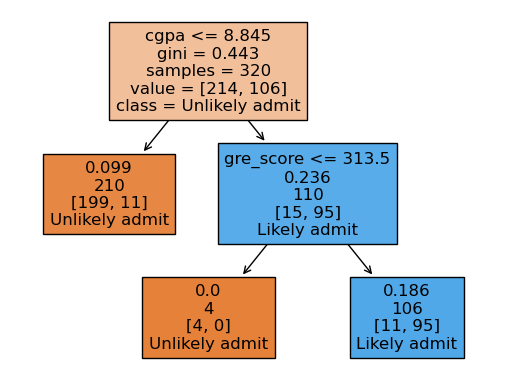

In [53]:
# Visualise decision tree
print(tree.export_text(dt, feature_names=X.columns.tolist()))

tree.plot_tree(dt, feature_names = x_train.columns.tolist(), max_depth=3, 
               class_names = ['Unlikely admit', 'Likely admit'],
               label = 'root', filled=True)

### Split Criteria

In [54]:
# self-made gini function to check Gini impurity value
def gini(data):
    """Calculate the Gini Impurity Score
    """
    data = pd.Series(data)
    return 1 - sum(data.value_counts(normalize=True)**2)
   
gi = gini(y_train)
print(f'Gini impurity at root: {round(gi,3)}')

Gini impurity at root: 0.443


In [55]:
# self-made info_gain function to check Information gain value
def info_gain(left, right, current_impurity):
    """Information Gain associated with creating a node/split data.
    Input: left, right are data in left branch, right banch, respectively
    current_impurity is the data impurity before splitting into left, right branches
    """
    # weight for gini score of the left branch
    w = float(len(left)) / (len(left) + len(right))
    return current_impurity - w * gini(left) - (1 - w) * gini(right)

In [56]:
# use info_gain over ALL values of cgpa to determine verify how the split on cgpa was determined
info_gain_list = []
for i in x_train.cgpa.unique():
    left = y_train[x_train.cgpa<=i]
    right = y_train[x_train.cgpa>i]
    info_gain_list.append([i, info_gain(left, right, gi)])

ig_table = pd.DataFrame(info_gain_list, columns=['split_value', 'info_gain']).sort_values('info_gain',ascending=False)
ig_table.head(10)

,split_value,info_gain
10,8.84,0.296932
124,8.85,0.291464
139,8.88,0.290704
18,8.90,0.290054
98,8.83,0.287810
110,8.87,0.286050
152,8.94,0.284714
57,8.96,0.284210
96,8.80,0.283371
21,9.00,0.283364


Text(0, 0.5, 'info gain')

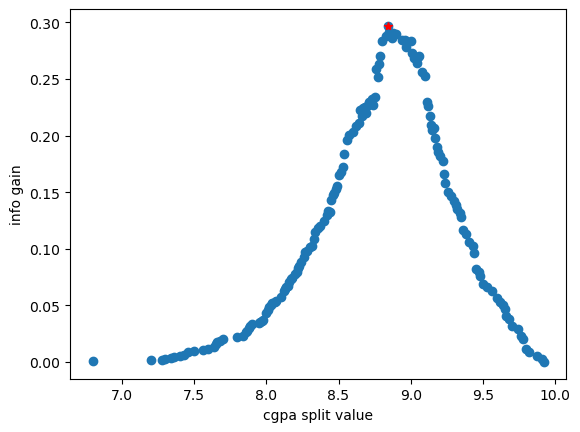

In [59]:
# plot the info_gain values
plt.plot(ig_table['split_value'], ig_table['info_gain'],'o')
plt.plot(ig_table['split_value'].iloc[0], ig_table['info_gain'].iloc[0],'r*')
plt.xlabel('cgpa split value')
plt.ylabel('info gain')